In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# Directorios de entrenamiento, validación y prueba
train_dir = r'D:\Python\TESIS\CLUSTERS_C3_CALC_K\train'
val_dir = r'D:\Python\TESIS\CLUSTERS_C3_CALC_K\val'
test_dir = r'D:\Python\TESIS\CLUSTERS_C3_CALC_K\test'

In [3]:
# Configurar TensorFlow para que use solo la GPU 0 y optimizar el uso de la memoria
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU configurada correctamente.")
    except RuntimeError as e:
        print(e)

# Parámetros de la red y del entrenamiento
img_width, img_height = 170, 170  # Ajustado al lienzo de 170x170 píxeles
batch_size = 32
epochs = 50
num_classes = 3 # Número de categorías

GPU configurada correctamente.


In [4]:
# Generadores de datos para la carga y preprocesamiento de imágenes en escala de grises
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Generadores para train, val y test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)  # No se necesita barajar para evaluar

# Construcción de la red neuronal convolucional
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Configuración del modelo de entrenamiento
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Callbacks para guardar el mejor modelo y detener temprano
checkpoint = ModelCheckpoint('best_model_C3.h5', verbose=1, save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping],
    workers=tf.data.experimental.AUTOTUNE,
    use_multiprocessing=True)

# Evaluación del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 447 images belonging to 3 classes.
Found 85 images belonging to 3 classes.
Found 46 images belonging to 3 classes.
Epoch 1/50
12/13 [==========================>...] - ETA: 0s - loss: 1.1054 - accuracy: 0.3629
Epoch 1: val_loss improved from inf to 1.09277, saving model to best_model_C3.h5
13/13 [==============================] - 5s 108ms/step - loss: 1.1035 - accuracy: 0.3735 - val_loss: 1.0928 - val_accuracy: 0.3438
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.0962 - accuracy: 0.3349
Epoch 2: val_loss improved from 1.09277 to 1.07168, saving model to best_model_C3.h5
13/13 [==============================] - 1s 62ms/step - loss: 1.0962 - accuracy: 0.3349 - val_loss: 1.0717 - val_accuracy: 0.4688
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.0732 - accuracy: 0.4578
Epoch 3: val_loss improved from 1.07168 to 1.06257, saving model to best_model_C3.h5
13/13 [==============================] - 1s 62ms/step - loss: 1.0732 - accuracy: 0.45

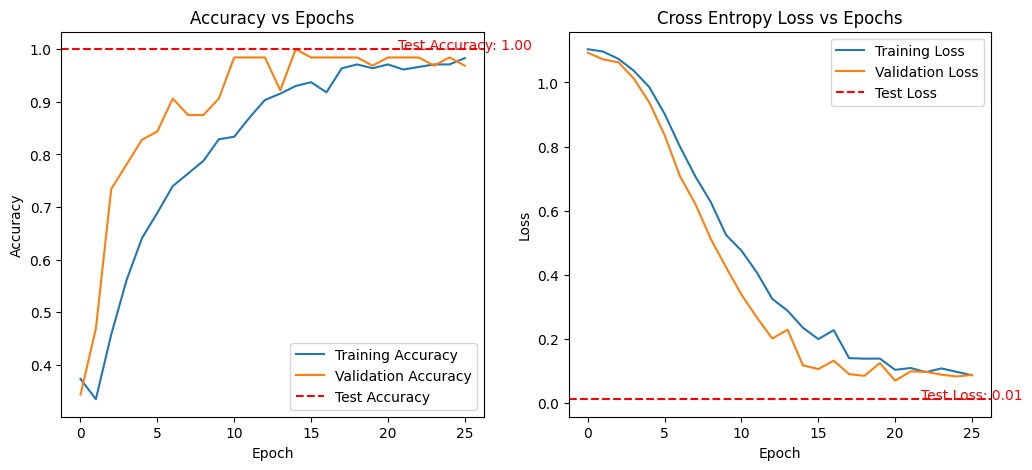

In [5]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Línea para Test
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.text(len(history.history['accuracy']) - 1, test_accuracy, f'Test Accuracy: {test_accuracy:.2f}', color='r', ha='center')


# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Línea para Test
plt.title('Cross Entropy Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.text(len(history.history['loss']) - 1, test_loss, f'Test Loss: {test_loss:.2f}', color='r', ha='center')

plt.show()
